# Analyze Rock vs. No Rock Dataset

2021-29-12

Tasks:
* Fit a linear mixed-effects model
* Calculate estimated marginal means
* Calculate effect size for each pairwise comparison
* Visualize posterior for each pairwise comparison
* Summarize findings

---

## Import libraries

In [33]:
library("modules")
library("lme4")
library("emmeans")
library("pbkrtest")
library("lmerTest")
library("ggplot2")
library("gridExtra")
library("repr")

## Load project module

In [34]:
setwd("/Users/rosswilkinson/My Drive/projects")
# lib <- modules::use("./rock-no-rock/src")

## Load dataset

In [35]:
dat <- read.csv("./rock-no-rock/data/rock_no_rock_ergo.csv")

## Linear mixed-effects model

In [36]:
lm <- lmer(power ~ factor(condition) + (1 + factor(condition) | subject),
    data = dat)

## Estimated marginal means

In [37]:
emm <- emmeans(lm, ~condition)
emm

 condition emmean   SE df lower.CL upper.CL
         1    974 51.2 18      866     1081
         2    927 53.6 18      814     1039
         3    982 56.1 18      864     1100

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

## Pairwise comparisons

In [38]:
pairs(emm, infer = TRUE)

 contrast estimate   SE df lower.CL upper.CL t.ratio p.value
 1 - 2       46.88 8.21 18     25.9     67.8   5.708  0.0001
 1 - 3       -8.28 9.91 18    -33.6     17.0  -0.836  0.6863
 2 - 3      -55.16 7.55 18    -74.4    -35.9  -7.301  <.0001

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 
Conf-level adjustment: tukey method for comparing a family of 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 

## Effect sizes

In [39]:
eff_size(emm, sigma = sigma(lm), edf = 18)

 contrast effect.size    SE df lower.CL upper.CL
 1 - 2          1.493 0.361 18    0.735    2.252
 1 - 3         -0.264 0.319 18   -0.933    0.406
 2 - 3         -1.757 0.379 18   -2.553   -0.961

sigma used for effect sizes: 31.39 
Degrees-of-freedom method: inherited from kenward-roger when re-gridding 
Confidence level used: 0.95 

## Calculate CDF for each effect size

In [40]:
pnorm(1.493)
pnorm(0.264)
pnorm(1.757)

[1] 0.9322814

[1] 0.60411

[1] 0.9605411

## Visualize data

In [41]:
dat$condition <- factor(dat$condition,
    labels = c("ad libitum", "Minimal", "Locked"))

by_subject <- aggregate(power ~ subject + condition, mean, data = dat)

In [42]:
p1 <- ggplot(by_subject,
    aes(x = factor(condition, c("Locked", "ad libitum", "Minimal")),
    y = power, group = subject)) +
    geom_point(aes(colour = factor(subject)), size = 2, show.legend = FALSE) +
    geom_line(aes(colour = factor(subject)), show.legend = FALSE) +
    labs(x = "", y = "Maximal 1 s Power (W)") +
    theme(text = element_text(size = 20))

## Calculate percentage differences between each condition

In [43]:
locked <- by_subject$power[by_subject$condition == "Locked"]
adlib <- by_subject$power[by_subject$condition == "ad libitum"]
minimal <- by_subject$power[by_subject$condition == "Minimal"]

a <- (adlib - locked) / locked * 100
b <- (minimal - locked) / locked * 100
c <- (minimal - adlib) / adlib * 100

perc_diff <- as.vector(cbind(a, b, c))
comparison <- c(rep(1, 19), rep(2, 19), rep(3, 19))
m <- as.data.frame(cbind(perc_diff, comparison))
m$comparison <- factor(m$comparison)

## Violin plots of percentage differences

In [44]:
p2 <- ggplot(m, aes(x = comparison, y = perc_diff)) +
    geom_hline(yintercept = 0) +
    geom_violin(trim = FALSE, fill = "darkgray") +
    geom_boxplot(width = 0.1) +
    labs(x = "", y = "% Difference") +
    theme(text = element_text(size = 20)) +
    scale_x_discrete(labels =
        c("ad libitum\nvs.\nLocked", "Minimal\nvs.\nLocked",
        "Minimal\nvs.\nad libitum"))

## Combine plots

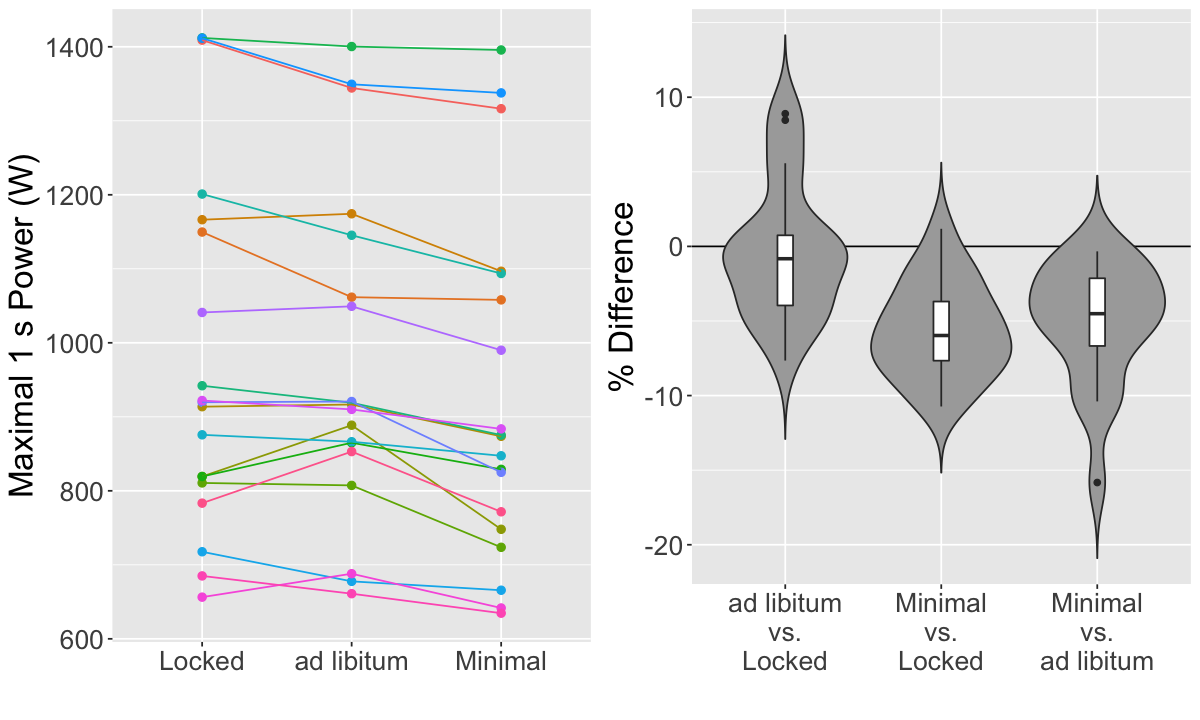

In [45]:
options(repr.plot.width = 10, repr.plot.height = 6)
p3 <- grid.arrange(p1, p2, nrow = 1)
dir <- "./rock-no-rock/results/figures/"
filename <- paste(dir, "rnr_results_power.png", sep = "")

## Save figure

In [46]:
ggsave(filename, plot = p3, width = 10, height = 6, units = "in", dpi = 300)

## Summary
Based on the posterior distribution of the percentage difference between each of the conditions, we can estimate the following probabilities:
* ad libitum vs. Locked = 60 % chance of decrease in maximal 1 s power
* Minimal vs. Locked = 96 % chance of decrease in maximal 1 s power
* Minimal vs. ad libitum = 93 % chance of decrease in maximal power